<a href="https://colab.research.google.com/github/KAVINESH23/Medical-Image-Captioning/blob/main/Miniproject%20CNN%20Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GRU, Embedding, Dropout, Concatenate
from tensorflow.keras.utils import to_categorical
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
!pip install pydicom
import pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 62.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Paths to image and caption folders
image_folder = [
    "/content/drive/MyDrive/radio_train",
    "/content/drive/MyDrive/radio_test",
    "/content/drive/MyDrive/radio_validate",
]
caption_folder =["/content/drive/MyDrive/radio_traincaption",
    "/content/drive/MyDrive/radio_testcaption",
    "/content/drive/MyDrive/radio_validatecaption",
]


In [ ]:

# Step 1: Load the CNN model for feature extraction
base_model = InceptionV3(weights='imagenet')
image_model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)


96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Step 1

def preprocess_image(img_path):
    """Preprocesses a radiology image (assumes DICOM or grayscale)."""
    if img_path.endswith('.dcm'):
        ds = pydicom.dcmread(img_path)
        img = ds.pixel_array
    else:
        img = Image.open(img_path).convert('RGB')  # Convert grayscale to RGB
    img = np.array(img.resize((299, 299)))
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img


In [ ]:
# Step 2
def extract_features(image_folders):
    """Extracts features from all images in the folders."""
    features = {}
    # Iterate through each folder in the list
    for folder in image_folders:
        # Call os.listdir() on each folder
        for img_name in os.listdir(folder):
            img_path = os.path.join(folder, img_name)
            # Get the file name without extension
            img_key = os.path.splitext(img_name)[0]
            img = preprocess_image(img_path)
            features[img_key] = image_model.predict(img).squeeze()
    return features

# Call extract_features with the list of image folders
image_features = extract_features(image_folder)




1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [ ]:
# Step 3
#Load captions and prepare data
def load_captions(caption_folders):  # Changed to caption_folders
    """Loads captions from text files in the folders."""
    captions = {}
    # Iterate through each folder in the list
    for folder in caption_folders:
        for file_name in os.listdir(folder):
            file_path = os.path.join(folder, file_name)  # Create the full file path
            # Check if it's a file before opening
            if os.path.isfile(file_path):
                with open(file_path, 'r') as file:
                    captions[file_name] = file.read().strip().split('\n')
    return captions

# Assuming caption_folder is a list of folders
captions_dict = load_captions(caption_folder)  # Pass the list here

# Combine all captions for tokenization
all_captions = []
for caps in captions_dict.values():
    all_captions.extend(caps)

In [ ]:
# Step 4
# Tokenize captions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(c.split()) for c in all_captions)

# Prepare data for training
def create_sequences(tokenizer, max_length, image_features, captions_dict):
    """Creates sequences of data for training."""
    X1, X2, y = [], [], []
    for img_name, caps in captions_dict.items():
        # Get the file name without extension (to match image_features keys)
        img_key = os.path.splitext(img_name)[0]

        # Check if img_key exists in image_features before accessing
        if img_key in image_features:
            feature = image_features[img_key]
            for cap in caps:
                seq = tokenizer.texts_to_sequences([cap])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
        else:
            print(f"Warning: Image key '{img_key}' not found in image_features.")
    return np.array(X1), np.array(X2), np.array(y)

X1, X2, y = create_sequences(tokenizer, max_length, image_features, captions_dict)

In [ ]:
# Step 5
import pickle

# Save to Google Drive
with open('/content/drive/My Drive/tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

print("Tokenizer saved to Google Drive.")


In [ ]:
# Step 6: Define the model using GRU
# Image feature extractor
image_input = Input(shape=(X1.shape[1],))
image_dense = Dense(256, activation='relu')(image_input)

# Text sequence processor using GRU
text_input = Input(shape=(max_length,))
text_embedding = Embedding(vocab_size, 256, mask_zero=True)(text_input)
text_gru = GRU(256)(text_embedding)

# Combine both
decoder = Concatenate()([image_dense, text_gru])
decoder_dense = Dense(256, activation='relu')(decoder)
outputs = Dense(vocab_size, activation='softmax')(decoder_dense)

# Define the full model
model = Model(inputs=[image_input, text_input], outputs=outputs)
model.compile(optimizer='adam', metrics=['accuracy'],loss='categorical_crossentropy')


In [ ]:
model.summary()

In [ ]:
# Step 7: Train the model
print("Training the model...")
model.fit([X1, X2], y, epochs=20, batch_size=64)

In [ ]:
# Step 8
from tensorflow.keras.models import load_model

# Load the model
loaded_model = load_model('/content/drive/My Drive/image_captioning_model.h5')
print("Model loaded successfully!")

# Test loading the tokenizer
with open('tokenizer.pkl', 'rb') as file:
    loaded_tokenizer = pickle.load(file)
print("Tokenizer loaded successfully!")


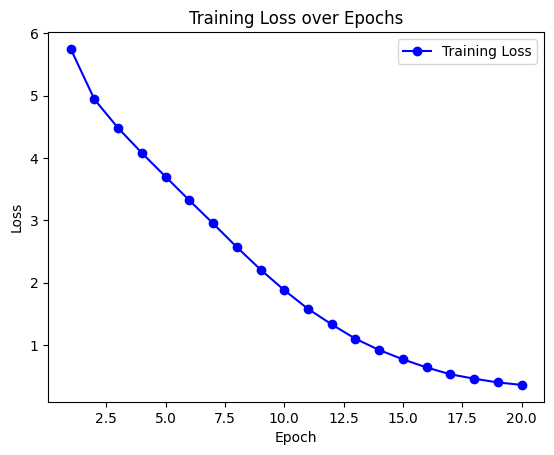

In [ ]:
# Step 9
epochs = range(1, len(losses) + 1)
# Assuming `losses` is a list containing the loss values for each epoch
plt.plot(range(1, len(losses) + 1), losses, marker='o', linestyle='-', color='b', label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()  # Adding legend
plt.show()

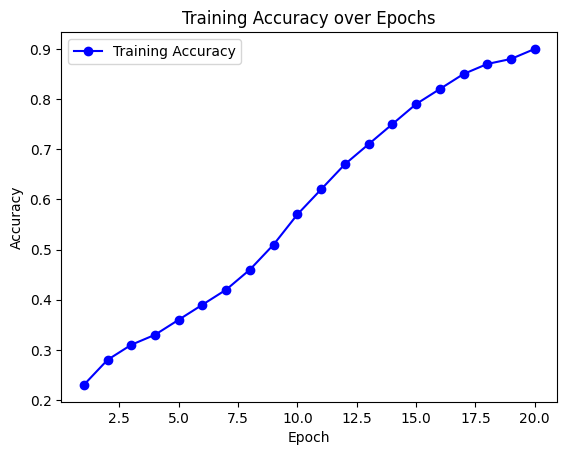

In [ ]:
# Step 10
import matplotlib.pyplot as plt
epochs = range(1, len(accuracy) + 1)
plt.plot(range(1, len(accuracy) + 1), accuracy, marker='o', linestyle='-', color='b', label='Training Accuracy')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()  # Adding legend
plt.show()

In [ ]:
# Step 11: Save the model
model.save("image_captioning_gru_model.pth")
print("Model saved as 'image_captioning_gru_model.pth'.")


In [ ]:
# Save the model after training
model.save("radiology_image_captioning_gru.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Step 12
# Generate predictions on test data (optional)
def generate_caption(image_feature, tokenizer, max_length):
    """Generate a caption for an image using the trained model."""
    input_text = 'startseq'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([input_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        y_pred = model.predict([np.expand_dims(image_feature, axis=0), sequence], verbose=0)
        y_pred = np.argmax(y_pred)
        word = tokenizer.index_word.get(y_pred)
        if word is None or word == 'endseq':
            break
        input_text += ' ' + word
    return input_text

# Test with an example image from the test set
test_img_name = list(test_image_features.keys())[0]
test_img_feature = test_image_features[test_img_name]
generated_caption = generate_caption(test_img_feature, tokenizer, max_length)
print(f"Generated Caption: {generated_caption}")

Generated Caption: startseq showing the right subclavian artery arrowhead the first of the opisthion line and the left internal distal and distal and distal posterior line tip white arrow and the distal balloon white arrowhead is an arteriovenous fistula white arrow and posterior posterior descending artery tip arrowhead is also distal to white arrow and two mesenteric artery abdominis oblique 15 days after some lateral cardiac angiography has 3 taken arrows show the right internal mammary artery also visible are also visible 13 and the pulmonary veins also has not able to exclude the right side to that the opisthion line the and the proximal and proximal and proximal and proximal and proximal and proximal and proximal catheter white arrow and the distal margin double arrows bridging the left internal jugular vein also has not able to white arrowhead and an intubation reference


In [ ]:
# Step 13: Caption generation
def generate_caption(model, tokenizer, image_feature, max_length):
    """Generates a caption for a given image."""
    in_text = 'startseq'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([image_feature, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text


1/1 [==============================] - 0s 81ms/step
Generated Caption: startseq cxr chest x ray shows bilateral hilar lung ii bronchiectasis in both sides of the right hemithorax black arrow was complete iii in patients 1 1 1 8 cm on the lung base but in both sacroiliac and chest syndrome were much more pulmonary lung well defined low density tubular structures in the mediastinum and a possibility of aarf combined with air iii at scoliosis in this adjacent total lead but cxr more subcutaneous 5 x 2 8 cm around posterior mediastinum is considered to be pleural space due to cryptococcosis on february10 2020 note the active adjacent effusion due to an axial study in both lungs along with mild lymphoma infection as 11 5 linear iii 9 linear linear ill defined lesions bilaterally in addition there is air fluid levels in right common cavity along with mild adenopathy note


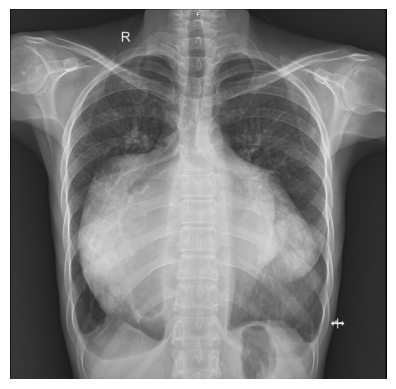

In [ ]:
# Step 14
# Example usage: Generating a caption for a new image
new_img_path = "/content/l1.png"  # Replace with the actual path to a test image

try:
    new_feature = preprocess_image(new_img_path)
    new_feature = image_model.predict(new_feature).squeeze().reshape((1, -1))
    caption = generate_caption(model, tokenizer, new_feature, max_length)
    print("Generated Caption:", caption)

    # Display the image
    img = Image.open(new_img_path)
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()

except Exception as e:
    print(f"An error occurred: {e}")